# PL03: Implementación del Bipedal Walker de OpenAI gymnasium

### Práctica realizada por Víctor Vega Sobral

El objetivo de esta práctica es entrenar un agente por aprendizaje por refuerzo, concretamente el modelo Bipedal Walker, para que sea capaz de caminar por terrenos con un relevo irregular.

Para ello, se usará la [propia documentación de OpenAI Gymnasium](https://gymnasium.farama.org/environments/box2d/bipedal_walker/), junto a la [información disponible en una sección específica de la página Pylessons](https://pylessons.com/BipedalWalker-v3-PPO). Pylessons también tiene un [video en Youtube donde se explica lo presente en la página web](https://www.youtube.com/watch?v=2Epn__SRHns).

Dichas fuentes contienen información muy útil tanto para la implementación del modelo como para su comprensión y explicación paso a paso. 

<img src="images/imagen_walker.jpg" alt="Imagen Bipedal Walker" width="400">



#### Importación de bibliotecas necesarias



In [36]:
import gymnasium as gym
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_probability as tfp




### Referencias y enlaces de interés

Además de los enlaces anteriores, a continuación se dejan otras referencias y enlaces que pueden resultar de interés.

1. [Código fuente del modelo de Pylessons](https://github.com/pythonlessons/Reinforcement_Learning)
2. [Repositorio de Github de la PLE03](https://github.com/VforVitorio/PLE03)
3. [Video solucionando errores de instalación de Gymnasium en Windows](https://www.youtube.com/watch?v=gMgj4pSHLww&t=148s)
4. [Repositorio con otras explicaciones útiles de este modelo](https://github.com/openai/gym/wiki/BipedalWalker-v2).

In [37]:
__author__ = "Victor Vega Sobral"

## Primeros pasos

### Validación de las bibliotecas

Una vez instaladas las bibliotecas necesarias de requirements.txt, se procede a copiar el primer bloque de código que se encuentra en la documentación de Gymnasium. Este código servirá para validar que se renderiza el modelo y los componentes de la librería.

También se ha creado un archivo "validation.py" donde se puede encontrar este mismo bloque.

El código se deja como comentado, puesto que su ejecución supone la creación de una pantalla de Pygame y su posterior parada puede dar lugar a salidas de celdas con posibles errores.




In [38]:
# import gymnasium as gym

# # Initialise the environment
# env = gym.make("LunarLander-v3", render_mode="human")

# # Reset the environment to generate the first observation
# observation, info = env.reset(seed=42)
# for _ in range(1000):
#     # this is where you would insert your policy
#     action = env.action_space.sample()

#     # step (transition) through the environment with the action
#     # receiving the next observation, reward and if the episode has terminated or truncated
#     observation, reward, terminated, truncated, info = env.step(action)

#     # If the episode has ended then we can reset to start a new episode
#     if terminated or truncated:
#         observation, info = env.reset()

# env.close()


### Introducción

Para mayor facilidad en la realización de la práctica y posterior comprensión de los conocimientos por parte de otras personas, se procede a la explicación de aspectos básicos de la librería y el aprendizaje por refuerzo. Todo lo explicado en este punto se encuentra traducido de la [explicación oficial de la biblioteca](https://gymnasium.farama.org/introduction/basic_usage/), siendo algunas de las partes resumidas. 

El uso de estas explicaciones se debe a la calidad de las explicaciones, además de resultar una fuente totalmente fiable de información, libre de posibles errores.

#### Interacción con el entorno

En el aprendizaje por refuerzo, el clásico "bucle agente-entorno", representado en la imagen a continuación, es una representación simplificada de cómo un agente y el entorno interactúan entre sí. 

El agente recibe una observación sobre el entorno, luego selecciona una acción que el entorno utiliza para determinar la recompensa y la siguiente observación. El ciclo se repite hasta que el entorno termina (se finaliza), como se puede observar en la siguiente imagen:

<div style="text-align: center;">
  <img src="images/flujo_funcionamiento.png" alt="Imagen Funcionamiento de Aprendizaje por Refuerzo" width="350">
</div>

#### Explicación básica de algunos componentes del código

Primero, se crea un entorno con `make()`, especificando el parámetro `render_mode`, que define cómo se visualizará el entorno [ver la documentación de `Env.render()` para más detalles.](https://gymnasium.farama.org/api/env/#gymnasium.Env.reset) En este ejemplo, usamos el entorno **"LunarLander"**, donde el agente controla una nave que debe aterrizar de forma segura.

Tras inicializar el entorno, usamos `env.reset()` para obtener la primera observación y datos adicionales. Si se desea inicializar el entorno con una semilla aleatoria o parámetros específicos, se pueden usar los argumentos `seed` u `options`.

Para continuar el bucle **agente-entorno** hasta que el entorno termine (un número desconocido de pasos), definimos la variable `episode_over` para indicar cuándo detenernos y usamos un bucle `while`.

El agente realiza una acción con `env.step()`, que ejecuta la acción seleccionada (en este caso, aleatoria con `env.action_space.sample()`). Esto simula una interacción, como mover un robot o presionar un botón, lo que provoca un cambio en el entorno. Como resultado, el agente recibe:
1. Una nueva observación del entorno actualizado.
2. Una recompensa asociada a la acción (positiva o negativa).

El entorno puede terminar después de algunos pasos, lo que se llama un **estado terminal** (por ejemplo, si el robot se estrella o completa su tarea). `env.step()` devuelve una señal `terminated` cuando esto ocurre. También podemos definir un límite de tiempo para finalizar el episodio, lo que activa la señal `truncated`. Si cualquiera de estas señales (`terminated` o `truncated`) es `True`, el episodio termina. En ese caso, podemos reiniciar el entorno con `env.reset()`.


## Bipedal Walker

A partir de este punto, **comienza en si lo referente a la implementación del Bipedal Walker**. Su importación se hace mediante la línea de código `gymnasium.make("BipedalWalker-v3")`. 

En esta celda introductoria de Markdown, se encuentran tanto explicaciones adaptadas como propias del estudiante, junto con algunas tablas e imágenes que refuerzan el entendimiento del modelo.

### Descripción

Se trata de un entorno de un robot con 4 articulaciones, habiendo dos versiones del entorno:
1. Normal, con un terreno levemente irregular.
2. Hardcore, con escaleras y otro tipo de obstáculos.

Según la documentación, para resolver la versión normal, se requieren de 300 puntos en 1600 intervalos de tiempo. Para la versión más complicadas, el número asciende a 2000 intervalos de tiempo.

Cabe destacar que estos números presuntamente solo han sido conseguidos por unas 10 personas debida su complejidad, según lo comentado por Pylessons. Por tanto, no se espera que el rendimiento del modelo sea tan óptimo, puesto que ni el modelo propuesto en esta página alcanza estas marcas.


#### Espacio de acción

Se tratan de velocidades de motor en el intervalo [-1, 1] para cada una de las 4 articulaciones en las caderas y rodillas.

| Num | Nombre                                | Mínimo | Máximo |
|-----|---------------------------------------|--------|--------|
| 0   | Hip_1 (Torque / Velocidad)            | -1     | +1     |
| 1   | Knee_1 (Torque / Velocidad)          | -1     | +1     |
| 2   | Hip_2 (Torque / Velocidad)            | -1     | +1     |
| 3   | Knee_2 (Torque / Velocidad)          | -1     | +1     |


#### Espacio de observación

El estado consiste en diferentes variables, como velocidad angular, horizontal, vertical, posición de las articulaciones, el contacto de las piernas con el suelo y 10 mediciones del rango de los sensores lidar.

| Num | Observación                          | Mínimo | Máximo   | Media |
|-----|---------------------------------------|--------|----------|-------|
| 0   | hull_angle                           | 0      | 2*pi     | 0.5   |
| 1   | hull_angularVelocity                 | -inf   | +inf     | -     |
| 2   | vel_x                                 | -1     | +1       | -     |
| 3   | vel_y                                 | -1     | +1       | -     |
| 4   | hip_joint_1_angle                     | -inf   | +inf     | -     |
| 5   | hip_joint_1_speed                     | -inf   | +inf     | -     |
| 6   | knee_joint_1_angle                    | -inf   | +inf     | -     |
| 7   | knee_joint_1_speed                    | -inf   | +inf     | -     |
| 8   | leg_1_ground_contact_flag            | 0      | 1        | -     |
| 9   | hip_joint_2_angle                     | -inf   | +inf     | -     |
| 10  | hip_joint_2_speed                     | -inf   | +inf     | -     |
| 11  | knee_joint_2_angle                    | -inf   | +inf     | -     |
| 12  | knee_joint_2_speed                    | -inf   | +inf     | -     |
| 13  | leg_2_ground_contact_flag            | 0      | 1        | -     |
| 14-23 | 10 mediciones lidar                  | -inf   | +inf     | -     |








### Estrategias para caminar 

Existen 4 tipos de estrategias al caminar:

<div style="text-align: center;">
  <img src="images/estrategias_walker.png" alt="Estrategias de caminar del Bipedal Walker" width="350">
</div>

1. **Balance con las rodillas**: las rodillas del robot se mantienen alineadas para proporcionar un control eficiente y estabilidad mientras camina. Se trata de la estrategia óptima para enseñar al modelo a caminar en un entorno simulado, ya que proporciona un punto de equilibrio óptimo entre la velocidad y el control.

2. **Balance doble**: el Walker usa ambas piernas de forma más activa, resultando en un movimiento mucho más rápido, sacrificando estabilidad y control y provocando caídas más frecuentes. No obstante, es una estrategia útil para enseñar al caminante su máxima velocidad.

3. **Balance frontal**: pone énfasis en mantener la parte delantera del cuerpo equilibrada, siendo útil en posibles entornos inclinados o moverse hacia adelante más rápido en combinación con la estrategia anterior. Se trata, junto a la siguiente estrategia, en una de las más útiles para adaptarse a la versión Hardcore del modelo.

4. **Balance trasero**: similar al balance frontal, pero manteniendo más atención a la parte trasera. Es importante para que mantenga estabilidad en entornos donde se realicen otros movimientos más dinámicos y rápidos. 

### Entrenamiento a seguir

Se realizará un entrenamiento por fases, donde primero se intentará conseguir una estabilización del agente en el entorno con el balance de rodillas, para posteriormente aplicar los otros 3 tipos de estrategias para que comience a moverse. No obstante, en la ejecución del modelo como tal para caminar, se combinan las 4 estrategias.

#### Antes de seguir

No obstante, antes de seguir con la práctica, se dispone de un código de prueba para visualizar la interacción de un agente Walker con el entorno y comprobar su correcta instalación y funcionamiento. 

El código correspondiente se encuentra en el archivo `validation_walker.py`, siendo este el archivo oficial de OpenAI gymnasium. Dado que no se especifica en la documentación como ejecutarlo, para extraer el código se debe navegar a los envs que se instalan al instalar la propia librería y allí se encuentra el código fuente de esta demo.

Los resultados arrojados por terminal durante la ejecución son los siguientes son los siguientes:

<div style="text-align: center;">
  <img src="images/captura_terminal.png" alt="Salida de la demo por terminal" width="350">
</div>

El entorno BipedalWalker utiliza un espacio de acción continuo, donde los valores que controlan las articulaciones del robot (hull, legs) varían entre pequeños rangos. 

En la captura de la terminal de la demo, podemos ver cómo las articulaciones del robot, como el cuerpo (hull) y las piernas (leg0 y leg1), toman valores precisos en cada paso, con oscilaciones mínimas pero consistentes. Los valores oscilan entre pequeñas variaciones en cada eje, como se observa en los pasos 60 y 80, con recompensas negativas y positivas, respectivamente.

Estos números, aunque no tengan mucho sentido para un observador humano, son fundamentales para el agente de inteligencia artificial que controla al robot. Dado que el espacio de acción es continuo, hay miles de posibles valores entre -1 y 1 que el agente puede explorar para decidir la acción óptima en cada momento.




## Entrenamiento del modelo

Se procede al entrenamiento del modelo, siguiendo la estrategia definida anteriormente. Para ello, se usará el algoritmo de POO de aprendizaje por refuerzo. 

### Componentes de PPO

- **Política**: La política (denotada como π) es el conjunto de reglas que el agente sigue para decidir qué acciones tomar. En PPO, esta política es representada por una red neuronal.

- **Función de valor:** PPO también usa una función de valor (denotada como V) que estima el valor esperado de la recompensa futura que el agente puede obtener a partir de un estado dado. Esto ayuda a optimizar las decisiones a largo plazo.

- **Función objetivo:** El objetivo de PPO es maximizar la recompensa que el agente obtiene a lo largo de su vida útil. Sin embargo, PPO introduce una restricción para garantizar que la política no cambie demasiado de un paso a otro, lo que podría causar inestabilidad en el entrenamiento. Se trata de algo perfecto para nuestro Walker, puesto que limitará saltos muy grandes en los valores de las articulaciones que pueden resultar contraproducentes.

- **Optimización:** PPO optimiza una función objetivo que permite hacer pequeñas actualizaciones a la política. La actualización de la política se limita mediante un "clip" en la función de pérdida, lo que asegura que la política no cambie demasiado entre iteraciones sucesivas.

### Funcionamiento de PPO
- **Experiencia en lotes:** PPO utiliza lotes de experiencia para calcular las políticas y actualizar la red neuronal. La experiencia se recopila ejecutando el agente en el entorno durante un número determinado de pasos.

- **Estimación de ventajas:** A partir de la experiencia acumulada, PPO calcula las ventajas de las acciones tomadas, que son una medida de qué tan buena fue una acción comparada con otras posibles en ese estado. 

- **Actualización de la política:** PPO usa un algoritmo de optimización por gradientes para actualizar los parámetros de la red neuronal de la política. Esto se realiza usando el gradiente descendente, pero se limita la magnitud del cambio en cada paso de optimización usando el método de "clipping".

- **Clipping**: La técnica de "clipping" se introduce para evitar que el cambio de política sea demasiado grande entre actualizaciones. Si la relación de probabilidad entre la política actual y la anterior es demasiado grande, PPO limita este cambio para evitar que el agente haga un gran salto en la política, lo que puede ser contraproducente.


### Explicación del tipo de entrenamiento

Junto con POO, para seguir la estrategia definida de un balance estático y un posterior balance dinámico, me remitiré a implementar un **algoritmo Actor Critic**, que combinan el valor y la política. Las imágenes explicativas se pueden encontrar en la explicación dada por Pylessons.

1. **Actor**.
    - Responsables de tomar decisiones sobre qué acción ejecutar dado el estado del entorno. Aquí se define la política del agente.
    - El actor toma el estado del entorno y selecciona una acción basada en la poítica. Es decir, usa la información del entorno para ejecutar una acción.

<div style="text-align: center;">
  <img src="images/actor_model.png" alt="Explicación del actor" width="400">
</div>

2. **Crítico**.
    - Evalúa las acciones del actor, estimando el valor de las acciones tomadas y evaluando la recompensa a largo plazo que se podrá obtener desde el estado actual.
    - Calcula el valor de la función de valor, como el Q-value, permitiendo dar una retroalimentación al actor sobre la calidad de decisiones que está tomando para mejorar la política.

<div style="text-align: center;">
  <img src="images/critic_model.png" alt="Explicación del Crítico" width="400">
</div>

#### Caso personal

Debido a que se quiere pasar de un entrenamiento estático a uno dimámico, el enfoque será el del algoritmo previamente dicho: 

1. **Estabilización estática:** En este paso, el objetivo principal es entrenar al agente para que logre caminar sin caerse, lo cual implica entrenar la política de manera que se logre un comportamiento estable. El actor estaría seleccionando acciones para lograr este equilibrio, mientras que el crítico proporcionaría una retroalimentación sobre qué tan bien se están haciendo esas acciones para mantenerse equilibrado.



2. **Optimización dinámica (velocidad):** Una vez que el agente ha aprendido a mantenerse estable, el siguiente paso sería optimizar su rendimiento, buscando no solo estabilidad, sino también velocidad. En este caso, el actor seguiría eligiendo acciones para maximizar la velocidad, mientras que el crítico continuaría evaluando esas acciones con base en las recompensas obtenidas (en este caso, acelerando el movimiento sin perder el equilibrio).

La siguiente imagen creada por el autor de Pylessons resume a la perfección la estructura de este tipo de modelo: 

<div style="text-align: center;">
  <img src="images/actor_critic_model.png" alt="Modelo actor-critic" width="600">
</div>




### Desarrollo del código

A partir de este punto, se procede a hacer un desarrollo de un código independiente al de las fuentes consultadas. Lo que se mantiene es la estructura del código, con una clase actor y otra agent para entrenar el modelo, aplicando los cambios específicos para un modelo continuo y no discreto.

Para facilitar el desarrollo y tras esta explicación, se usarán librerías como Keras o Tensorflow que puedan simplificar el desarrollo del modelo, sin partir de una base scracth, puesto que dicha complejidad sería inabarcable.

#### Clase actor-critic

In [39]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

class ActorCriticNetwork(tf.keras.Model):
    def __init__(self, action_dim, hidden_units=(256, 256)):
        super(ActorCriticNetwork, self).__init__()
        
        # Shared network layers
        self.shared_layers = [
            layers.Dense(hidden_units[0], activation='relu'),
            layers.Dense(hidden_units[1], activation='relu')
        ]
        
        # Actor (policy) network output
        self.actor_output = layers.Dense(action_dim, activation='tanh')
        
        # Critic (value function) network output
        self.critic_output = layers.Dense(1)
    
    def call(self, state):
        # Shared layers
        x = state
        for layer in self.shared_layers:
            x = layer(x)
        
        # Actor and Critic outputs
        action_mean = self.actor_output(x)
        value = self.critic_output(x)
        
        return action_mean, value
    
    def get_action(self, state, noise_scale=0.1):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        action_mean, _ = self(state)
        
        # Add noise to the action mean
        action = action_mean[0].numpy() + np.random.normal(0, noise_scale, size=action_mean.shape[1])
        
        # Clip action to be within valid range [-1, 1]
        return np.clip(action, -1, 1)


#### Clase agente

In [40]:
class BipedalWalkerAgent:
    def __init__(self, state_dim, action_dim, learning_rate=3e-4):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.network = ActorCriticNetwork(action_dim)
        
        # Actor-Critic Network
        self.network = ActorCriticNetwork(action_dim)
        
        # Compile the network
        self.network.compile(optimizer='adam')
        
        # Hyperparameters
        self.gamma = 0.99  # Discount factor
        self.learning_rate = learning_rate
    
    def train(self, states, actions, rewards, next_states, dones):
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        
        with tf.GradientTape() as tape:
            # Compute current and next values
            _, current_values = self.network(states)
            _, next_values = self.network(next_states)
            
            # Compute TD target
            targets = rewards + self.gamma * next_values.numpy() * (1 - dones)
            
            # Compute combined loss
            value_loss = tf.reduce_mean(tf.square(targets - current_values))
            policy_loss = -tf.reduce_mean(value_loss)
            total_loss = value_loss + policy_loss
        
        # Compute gradients and apply
        gradients = tape.gradient(total_loss, self.network.trainable_variables)
        self.network.optimizer.apply_gradients(zip(gradients, self.network.trainable_variables))
        
        return total_loss.numpy()


#### Entrenamiento del modelo de gymnasium

In [41]:
def train_bipedal_walker(episodes=500, max_steps=1600, render=False):
    # Initialize environment
    env = gym.make('BipedalWalker-v3')
    
    # Get dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    # Create agent
    agent = BipedalWalkerAgent(state_dim, action_dim)
    
    # Training logs
    episode_rewards = []  # Lista para almacenar las recompensas
    best_reward = float('-inf')
    best_model = None
    
    for episode in range(episodes):
        # Reset environment
        state, _ = env.reset()
        total_reward = 0
        
        # Lists to store episode data
        states, actions, rewards, next_states, dones = [], [], [], [], []
        
        for step in range(max_steps):
            # Get action from agent
            action = agent.network.get_action(state)
            
            # Step environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            # Store experience
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(terminated or truncated)
            
            # Update state and reward
            state = next_state
            total_reward += reward
            
            # Check if episode is done
            if terminated or truncated:
                break
        
        # Train agent on episode data
        if len(states) > 1:
            loss = agent.train(
                np.array(states), 
                np.array(actions), 
                np.array(rewards), 
                np.array(next_states), 
                np.array(dones)
            )
        
        # Log episode results
        episode_rewards.append(total_reward)  # Agregamos la recompensa total del episodio
        
        # Save best model
        if total_reward > best_reward:
            best_reward = total_reward
            best_model = agent.network
        
        # Print progress
        if episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward:.2f}")
    
    # Close environment
    env.close()
    
    return np.array(episode_rewards), best_model  # Convertimos la lista a un array de NumPy

In [42]:
# Run training
rewards, best_model = train_bipedal_walker(episodes=500, render=False)





d:\Users\O M E N\miniconda3\envs\aa_env\Lib\site-packages\keras\src\optimizers\base_optimizer.py:735: UserWarning: Gradients do not exist for variables ['actor_critic_network_7/dense_30/kernel', 'actor_critic_network_7/dense_30/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Episode 0, Total Reward: -36.01
Episode 10, Total Reward: -35.49
Episode 20, Total Reward: -92.76
Episode 30, Total Reward: -35.41
Episode 40, Total Reward: -33.03
Episode 50, Total Reward: -32.41
Episode 60, Total Reward: -31.41
Episode 70, Total Reward: -33.86
Episode 80, Total Reward: -30.10
Episode 90, Total Reward: -26.53
Episode 100, Total Reward: -36.73
Episode 110, Total Reward: -27.74
Episode 120, Total Reward: -39.10
Episode 130, Total Reward: -28.64
Episode 140, Total Reward: -28.62
Episode 150, Total Reward: -28.95
Episode 160, Total Reward: -34.61
Episode 170, Total Reward: -31.32
Episode 180, Total Reward: -29.04
Episode 190, Total Reward: -35.14
Episode 200, Total Reward: -27.74
Episode 210, Total Reward: -33.96
Episode 220, Total Reward: -33.60
Episode 230, Total Reward: -28.13
Episode 240, Total Reward: -29.78
Episode 250, Total Reward: -36.75
Episode 260, Total Reward: -29.02
Episode 270, Total Reward: -35.36
Episode 280, Total Reward: -33.47
Episode 290, Total Reward

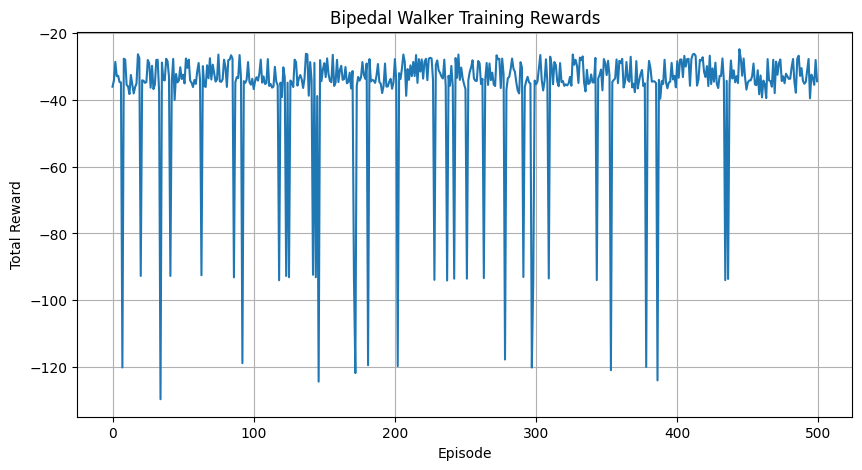

In [43]:
# Graficar los rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards)  # Ahora rewards es un array de NumPy válido
plt.title('Bipedal Walker Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

### Conclusiones de la gráfica y del entrenamiento

Los resultados de la gráfica muestran las diferentes recompensas obtenidas por el modelo a lo largo de los diferentes episodios del entrenamiento. Todas ellas han estado por debajo del 0, lo que indica que el modelo no está siendo capaz de caminar bien por su entorno. 

No obstante, la existencia de picos de bajada y luego de subida indican que el modelo es capaz de tener unos resultados más satisfactorios en algunos de los episodios, lo que puede indicar que **está consiguiendo balancearse de forma estática durante un período de tiempo considerable**.

De ser así este resultado y dada la complejidad del problema, se podría considerar esto como un resultado bastante satisfactorio para una fase inicial de desarrollo de la solución al problema. 

Se confirmará esta conclusión en la renderización de la ventana gráfica, para ver si realmente el modelo es capaz de estabilizarse correctamente en alguno de los episodiso.

#### Persistencia de los pesos

Se procede a guardar el modelo con el mejor rendimiento, para poder ser usado y renderizado posteriormente.

In [44]:
def save_best_model(model, filename='best_bipedal_walker_model'):
    # Ensure the model is not None
    if model is not None:
        # Save weights
        model.save_weights(f'{filename}.weights.h5')
        print(f"Model saved to {filename}.weights.h5")
    else:
        print("No model to save!")

save_best_model(best_model, filename='mi_bipedal_walker')

Model saved to mi_bipedal_walker.weights.h5


## Visualización del Walker

Con el objetivo de tener unas conclusiones visuales de los resultados, se procede a crear una función que renderice el entorno de Gymnasium, cargando los pesos del modelo generado. Esta versión tendrá 10 episodios, en los que se podrá ver el rendimiento aproximado del modelo.

Debido a las recompensas negativas extraídas de la gráfica, no se esperan grandes resultados a la hora de ejecutar el movimiento, por lo que una solución satisfactoria dada la complejidad de este modelo puede ser simplemente conseguir la estabilización estática del bípedo.

In [45]:
def visualize_bipedal_walker(loaded_model, episodes=10):  # Cambiado el nombre del parámetro
    env = gym.make('BipedalWalker-v3', render_mode='human')
    print("Visualizando modelo guardado...")
    
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        
        while True:
            action = loaded_model.get_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            
            if terminated or truncated:
                print(f"Episodio {episode+1}: Recompensa={total_reward:.2f}")
                break
    
    env.close()


In [46]:
def load_and_visualize(num_episodes=10):
    env = gym.make('BipedalWalker-v3')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    loaded_model = ActorCriticNetwork(action_dim)
    loaded_model.build((None, state_dim))
    loaded_model.load_weights('mi_bipedal_walker.weights.h5')
    
    # Llamada corregida sin keyword argument
    visualize_bipedal_walker(loaded_model, num_episodes)

In [2]:
# # Ejecutar
# load_and_visualize(num_episodes=20)

### Conclusiones de visualización

<div style="text-align: center;">
  <img src="images/mi_modelo.png" alt="Captura del modelo entrenado" width="400">
</div>


Como se puede observar en la imagen y en la ejecución del programa, en el **episodio número 3**, el robot consigue estabilizarse, en una posición dispuesta para la salida una vez se mejorase el entrenamiento del balanceo dinámico del modelo.

Aunque no se ha conseguido que el bípedo sea capaz de caminar (en algunos episodios tras los primeros pasos se cae y reinicia), el hecho de que en muchos de los episodios consiga estabilizarse y tener unas recompensas cercanas al 0 se puede considerar un buen resultado, dado el contexto y complejidad del problema que se ha podido observar tras una breve investigación por foros y repositorios bastante conocidos (StackOverflow, issues abiertas en el repositorio oficial de OpenAI, entre otros). 

Por tanto, a continuación se detallan las **áreas de mejora para este modelo**:

1. **Mejorar los resultados de las recompensas**: pese a que los resultados de las recompensas pueden considerarse aceptables, todos ellos están por debajo del 0, lo que indica que el bipedal walker no está siendo capaz de aprender a caminar correctamente. Por tanto:
  - Se debería *explorar el ajuste de los hiperparámetros*, como puede ser el número de neuronas, capas ocultas, tasa de aprendizaje, recompensas, etc.

  - Se debería *optimizar y mejorar el código de las clases y de entrenamiento*, puesto que se trata de un código que puede tener diferentes errores. Uno de los más notados es el warning que ofrece el propio TensorFlow a la hora de entrenar el modelo, arrojando un warning de inexistencia de un loss argument. No obstante, se han explorado soluciones a este problema, adoptando un método de entrenamiento mejorado. Sin embargo, el gran problema de este modelo es el del siguiente punto:

2. **Complejidad computacional del modelo**: se trata de un modelo complejo, con una elevada cantidad de neuronas y capas, gran número de episodios y pasos por episodios, por lo que el costo computacional es muy elevado (aproximadamente una hora y media de tiempo de ejecución). 

  - La *solución al warning previo* desembocó en un modelo con una complejidad aún mayor, tardando cerca de las 3 horas y con unos resultados levemente mejores, pero no significativos dado el aumento del tiempo de ejecución (las recompensas subían al -13).

3. **Probar diferentes enfoques o hacer una exploración más exhaustiva del problema**: sería recomendable buscar otras formas de abordar el problema, o hacer una exploración más exhaustiva de este. No obstante, dada la complejidad del modelo y el tiempo para la realización de esta práctica, se establece como *positivo el punto de partida alcanzado*, siendo capaz de estabilizar el modelo estáticamente. 

4. **Optimizar el entrenamiento**: es recomendable finalmente explorar aumentar el número de episodios y de pasos, intentando desviar el trabajo de entrenamiento a la GPU para tener un entrenamiento más robusto en un tiempo menor. Se ha explorado esta opción, pero se requiere de una instalación de drivers específicos y un ordenador con gráfica dedicada, por lo que no se trata de una opción para todos los ordenadores. En mi caso, la Nvidia GTX 1050 no posee la fuerza suficiente para realizar estas tareas (mediante los drivers específicos y CUDA Toolkit), por lo que descarté esta opción. 


## Decisión final y justificación

El desarrollo de este modelo ha resultado en la adopción de conocimientos diferentes de algoritmos no vistos como POO, siendo un problema desafiante para aplicar conceptos del aprendizaje por refuerzo. Además, la labor llevada a cabo en la investigación para resolver el problema ha resultado de gran ayuda para la capacidad de análisis y resolución de modelos por aprendizaje por refuerzo.

No obstante, dados los resultados bastante pobres del modelo, he decidido realizar en un **nuevo notebook otro modelo de gymnasium**, más simple y abarcable, como es el problema del **coche en una pendiente continua**, en el que se espera poder obtener un resultado más satisfactorio.

Este notebook, por tanto, queda como un aporte de interés, donde se consigue una explicación bastante detallada de los pasos seguidos y la exploración de una solución al Bipedal Walker.